In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import circulant

In [120]:
win=sinc_hamming(4,4096)
win=win.reshape(4,-1)
ndat=4096*10
mat=np.zeros((ndat,4096))
mat[:4,:]=win

In [121]:
eigvals=np.fft.rfft(mat,axis=0)

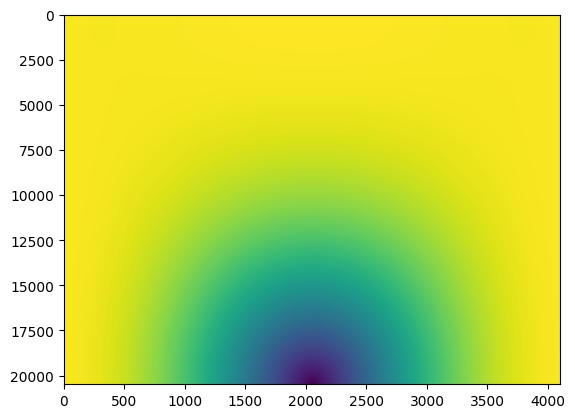

In [135]:
plt.imshow(np.abs(eigvals),aspect='auto',interpolation='none')

In [71]:
def ipfb(inft,win,ntap,thresh=0.):
    in_unft=np.fft.irfft(inft,axis=1)
    n=in_unft.shape[1]
    winmat=np.zeros(in_unft.shape)
    winmat[:ntap,:]=np.reshape(win,[ntap,n])
    winft=np.fft.rfft(winmat,axis=0)
    myft=np.fft.rfft(in_unft,axis=0)
    if thresh>0.:
        filt=np.abs(winft)**2/(thresh**2+np.abs(winft)**2)*(1+thresh**2)
        myft=myft*filt
    out=np.fft.irfft(myft/np.conj(winft),axis=0)
    return out
def sinc_hamming(ntap,lblock):
    N=ntap*lblock
    w=np.arange(0,N)-N/2
    return np.hamming(ntap*lblock)*np.sinc(w/lblock)

def sinc_hanning(ntap,lblock):
    N=ntap*lblock
    w=np.arange(0,N)-N/2
    return np.hanning(ntap*lblock)*np.sinc(w/lblock)

def sinc(ntap,lblock):
    N=ntap*lblock
    w=np.arange(0,N)-N/2
    return np.sinc(w/lblock)

def pfb(timestream, nchan=2048, ntap=4, window=sinc_hanning):

    # number of samples in a sub block
    lblock = 2*(nchan-1)
    # number of blocks
    nblock = timestream.size / lblock - (ntap - 1)
    if nblock==int(nblock): nblock=int(nblock)
    else: raise Exception("nblock is {}, should be integer".format(nblock))

    # initialize array for spectrum 
    spec = np.zeros((nblock,nchan), dtype=np.complex128)

    # window function
    w = window(ntap, lblock)

    def s(ts_sec):
        return np.sum(ts_sec.reshape(ntap,lblock),axis=0) # this is equivalent to sampling an ntap*lblock long fft - M


    # iterate over blocks and perform PFB
    for bi in range(nblock):
        # cut out the correct timestream section
        ts_sec = timestream[bi*lblock:(bi+ntap)*lblock].copy()

        spec[bi] = np.fft.rfft(s(ts_sec * w)) 

    return spec

In [3]:
ntap=4
nchan=2049
nslice=8*1024 # Mohan: this is num of pfb spectra
nn=2*(nchan-1)
x=np.random.randn(nslice+ntap-1,nn)
xx=np.ravel(x)
dwin=sinc_hamming(ntap,nn)
dxpfb=pfb(xx,nchan,ntap,sinc_hamming)

In [81]:
np.std(xx)

1.0000428743362466

In [4]:
dxpfb.shape

(8192, 2049)

In [5]:
out=ipfb(dxpfb,dwin,ntap,thresh=0.01)

In [72]:
out_unfilt=ipfb(dxpfb,dwin,ntap,thresh=-0.0)

In [36]:
to_cut=250
imax=out.shape[0]-to_cut

In [69]:
err=np.ravel(out[to_cut:imax,:]-x[to_cut:imax,:])
np.std(err)

0.004759671313954335

In [74]:
err_unfilt=np.ravel(out_unfilt[to_cut:imax,:]-x[to_cut:imax,:])
np.std(err_unfilt)

0.027427173949279106

In [38]:
err.shape

(31506432,)

(0.0, 1000000.0)

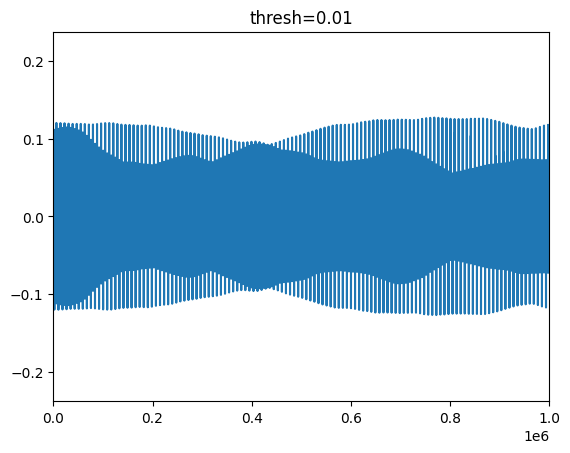

In [50]:
s=0
ds=1024**3
plt.ion()
plt.plot(err[s:s+ds])
plt.title("thresh=0.01")
plt.xlim(0,1000000)

(0.0, 1000000.0)

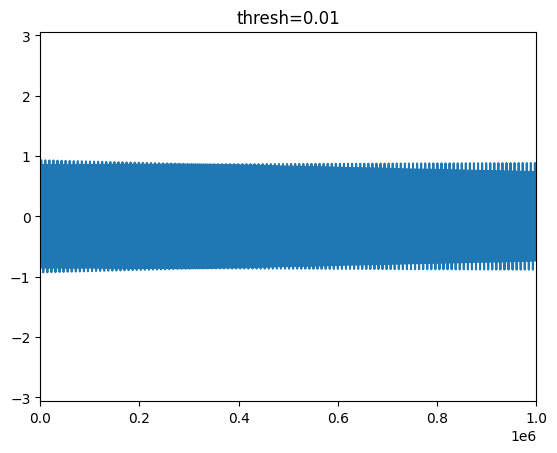

In [75]:
s=0
ds=1024**3
plt.ion()
plt.plot(err_unfilt[s:s+ds])
plt.title("thresh=0.01")
plt.xlim(0,1000000)

In [97]:
np.std(xx[to_cut*4096:to_cut*4096+1024**3])

1.0000807998473742

In [96]:
np.mean(xx[to_cut*4096:to_cut*4096+1024**3])

5.083541332264684e-07

In [92]:
pp=np.fft.rfft(xx[to_cut*4096:to_cut*4096+1024**3])

In [102]:
np.sqrt(len(xx[to_cut*4096:to_cut*4096+1024**3]))

5704.622686909275

In [93]:
np.sqrt(np.mean(np.abs(pp)**2))

5705.083462511648

In [95]:
np.sqrt(1024**3)

32768.0

In [85]:
np.sqrt(1024**2)

1024.0

In [61]:
ps_signal = np.sqrt(np.mean((np.abs(np.fft.rfft(xx[to_cut*4096:to_cut*4096+1024**3]))**2)))

In [62]:
ps_signal

5705.083462511648

In [43]:
errft=np.fft.rfft(err[:1024**3])
ps=np.abs(errft)
# plt.plot(ps)

In [79]:
errft_unfilt=np.fft.rfft(err_unfilt[:1024**3])
ps_unfilt=np.abs(errft_unfilt)
# plt.plot(ps)

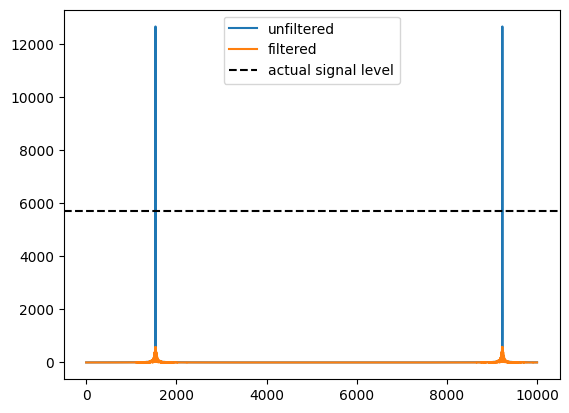

In [104]:
s=10000
ds=10000
plt.plot(ps_unfilt[s:s+ds],label='unfiltered')
plt.plot(ps[s:s+ds],label='filtered')
plt.axhline(ps_signal, ls='--',c='black',label='actual signal level')
plt.legend()